In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
belalsafy_egyptian_new_currency_2023_path = kagglehub.dataset_download('belalsafy/egyptian-new-currency-2023')

print('Data source import complete.')


100%|██████████| 395M/395M [00:03<00:00, 118MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision import models


In [ ]:
# المسارات الخاصة بك
data_train = Path(r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/train")
data_test = Path(r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/test")
data_val = Path(r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/valid")  # إن وجد

dirs = os.listdir(data_train)
classes = {k: v for k,v in zip(dirs, range(len(dirs)))}
classes

{'50': 0,
 '100': 1,
 '20': 2,
 '1': 3,
 '10': 4,
 '20 (new)': 5,
 '200': 6,
 '5': 7,
 '10 (new)': 8}

Found 2637 files belonging to 9 classes.


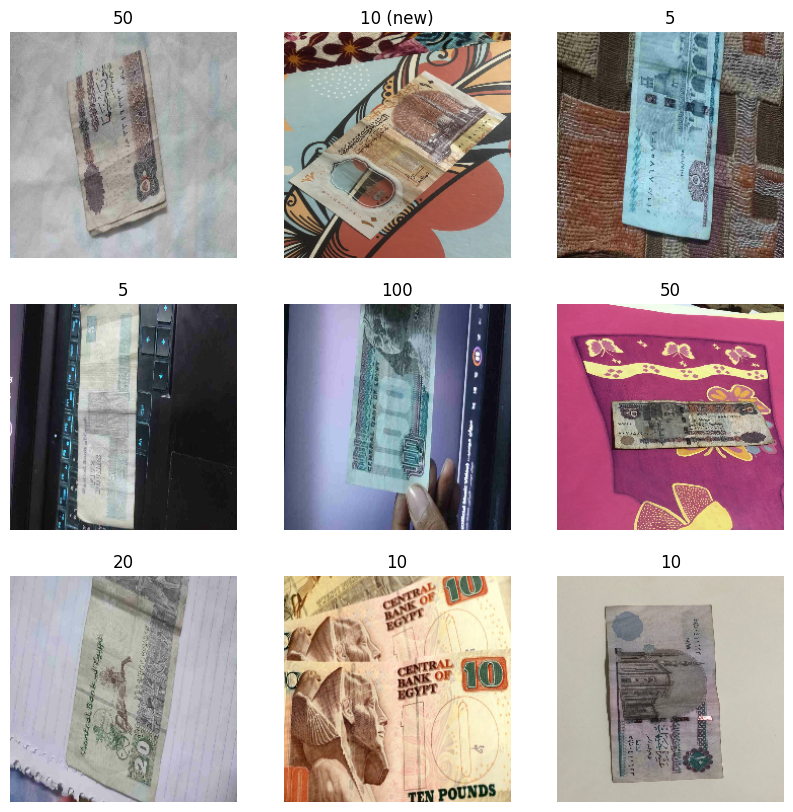

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/train",
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [ ]:
print("Training")
for class_name in classes:
  class_dir = os.path.join(data_train, class_name)
  num_files = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of files: {num_files}")
print()
print("Testing")
for class_name in classes:
  class_dir = os.path.join(data_test, class_name)
  num_files = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of files: {num_files}")
print("Validation")
for class_name in classes:
  class_dir = os.path.join(data_val, class_name)
  num_files = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of files: {num_files}")

Training
Class: 50, Number of files: 315
Class: 100, Number of files: 315
Class: 20, Number of files: 322
Class: 1, Number of files: 60
Class: 10, Number of files: 315
Class: 20 (new), Number of files: 346
Class: 200, Number of files: 313
Class: 5, Number of files: 334
Class: 10 (new), Number of files: 317

Testing
Class: 50, Number of files: 35
Class: 100, Number of files: 35
Class: 20, Number of files: 35
Class: 1, Number of files: 20
Class: 10, Number of files: 35
Class: 20 (new), Number of files: 30
Class: 200, Number of files: 35
Class: 5, Number of files: 35
Class: 10 (new), Number of files: 30
Validation
Class: 50, Number of files: 80
Class: 100, Number of files: 80
Class: 20, Number of files: 80
Class: 1, Number of files: 20
Class: 10, Number of files: 80
Class: 20 (new), Number of files: 130
Class: 200, Number of files: 80
Class: 5, Number of files: 80
Class: 10 (new), Number of files: 130


Training Total: 2633, Classes: ['50', '100', '20', '1', '10', '20 (new)', '200', '5', '10 (new)'], Counts: [315, 315, 322, 60, 313, 346, 311, 334, 317]
Testing Total: 288, Classes: ['50', '100', '20', '1', '10', '20 (new)', '200', '5', '10 (new)'], Counts: [35, 35, 35, 20, 33, 30, 35, 35, 30]
Validation Total: 757, Classes: ['50', '100', '20', '1', '10', '20 (new)', '200', '5', '10 (new)'], Counts: [80, 80, 80, 20, 79, 130, 78, 80, 130]


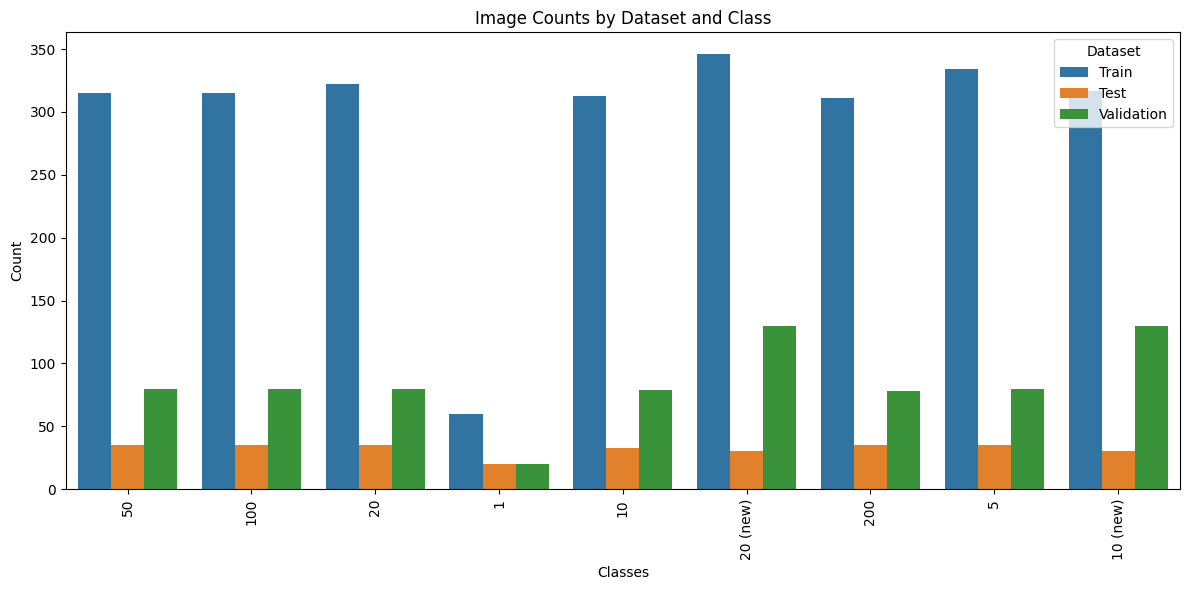

In [ ]:
def count_images(data_dir):
    """
    تحسب عدد الصور لكل فئة في المسار المحدد.
    """
    if not data_dir.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return 0, [], []

    class_names = os.listdir(data_dir)
    num_classes = len(class_names)
    all_count = []
    class_name = []
    total = 0

    for class_name in class_names:
        count = len(list(data_dir.glob(f'{class_name}/*.jpg')))
        total += count
        all_count.append(count)

    return total, class_names, all_count

# حساب الصور لكل من التدريب والاختبار والتحقق (إن وجد)
train_total, train_classes, train_counts = count_images(data_train)
test_total, test_classes, test_counts = count_images(data_test)

if data_val.exists():
    val_total, val_classes, val_counts = count_images(data_val)
else:
    val_total, val_classes, val_counts = 0, [], []

# طباعة التفاصيل للتأكد
print(f"Training Total: {train_total}, Classes: {train_classes}, Counts: {train_counts}")
print(f"Testing Total: {test_total}, Classes: {test_classes}, Counts: {test_counts}")
print(f"Validation Total: {val_total}, Classes: {val_classes}, Counts: {val_counts}")

# إعداد البيانات للرسم
datasets = ['Train'] * len(train_classes) + ['Test'] * len(test_classes) + ['Validation'] * len(val_classes)
classes = train_classes + test_classes + val_classes
counts = train_counts + test_counts + val_counts

data = pd.DataFrame({'Dataset': datasets, 'Class': classes, 'Count': counts})

# رسم الأعمدة
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Class', y='Count', hue='Dataset')
plt.title('Image Counts by Dataset and Class')
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

In [ ]:
pip install Augmentor

In [ ]:
import Augmentor
import os
from PIL import Image

# مسار البيانات الأصلية
data_train = r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/train"

# مسار البيانات الجديدة بعد التوازن
output_base_path = r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance"

# قائمة أسماء الفئات
class_names = os.listdir(data_train)

# تطبيق Augmentor على كل فئة
for class_name in class_names:
    class_path = os.path.join(data_train, class_name)
    output_directory = os.path.join(output_base_path, class_name)

    # تحقق من وجود المسار قبل البدء
    if not os.path.exists(class_path):
        print(f"الفئة {class_name} لا توجد في المسار {class_path}")
        continue

    # إنشاء مجلد الخرج إذا لم يكن موجودًا
    os.makedirs(output_directory, exist_ok=True)

    # تحويل الصور إلى RGB إن لزم الأمر
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        try:
            with Image.open(image_path) as img:
                if img.mode != "RGB":
                    img = img.convert("RGB")
                    img.save(image_path)
        except Exception as e:
            print(f"خطأ في تحويل الصورة: {image_path}, السبب: {e}")

    # تطبيق Augmentor
    print(f"Augmentor applied to category: {class_name}")
    p = Augmentor.Pipeline(class_path, output_directory=output_directory)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.sample(500)  # إنشاء 500 صورة جديدة لكل فئة


Augmentor applied to category: 50
Initialised with 315 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/50.

Processing <PIL.Image.Image image mode=RGB size=960x1280 at 0x7A4E3045CD90>: 100%|██████████| 500/500 [00:51<00:00,  9.67 Samples/s]


Augmentor applied to category: 100
Initialised with 315 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/100.

Processing <PIL.Image.Image image mode=RGB size=1500x1225 at 0x7A4F713EF310>: 100%|██████████| 500/500 [00:44<00:00, 11.17 Samples/s]


Augmentor applied to category: 20
Initialised with 322 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/20.

Processing <PIL.Image.Image image mode=RGB size=1280x960 at 0x7A4E307E37F0>: 100%|██████████| 500/500 [00:46<00:00, 10.65 Samples/s]


Augmentor applied to category: 1
Initialised with 60 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/1.

Processing <PIL.Image.Image image mode=RGB size=201x98 at 0x7A4E307C3FD0>: 100%|██████████| 500/500 [00:06<00:00, 78.38 Samples/s] 


Augmentor applied to category: 10
Initialised with 315 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/10.

Processing <PIL.Image.Image image mode=RGB size=1280x720 at 0x7A4E307C2DA0>: 100%|██████████| 500/500 [00:49<00:00, 10.11 Samples/s]


Augmentor applied to category: 20 (new)
Initialised with 346 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/20 (new).

Processing <PIL.Image.Image image mode=RGB size=640x426 at 0x7A4E304D01F0>: 100%|██████████| 500/500 [01:52<00:00,  4.43 Samples/s]


Augmentor applied to category: 200
Initialised with 313 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/200.

Processing <PIL.Image.Image image mode=RGB size=1024x474 at 0x7A4E307E0F70>: 100%|██████████| 500/500 [00:25<00:00, 19.35 Samples/s]


Augmentor applied to category: 5
Initialised with 334 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/5.

Processing <PIL.Image.Image image mode=RGB size=201x95 at 0x7A4E304CB6A0>: 100%|██████████| 500/500 [00:32<00:00, 15.42 Samples/s]


Augmentor applied to category: 10 (new)
Initialised with 317 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance/10 (new).

Processing <PIL.Image.Image image mode=RGB size=640x427 at 0x7A4E4EB77820>: 100%|██████████| 500/500 [01:16<00:00,  6.53 Samples/s]


Total image count = 4493 

-------------------------------------
Class name = 50
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 100
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 20
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 1
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 10
Count      = 496
Proportion = 0.1104
-------------------------------------
Class name = 20 (new)
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 200
Count      = 497
Proportion = 0.1106
-------------------------------------
Class name = 5
Count      = 500
Proportion = 0.1113
-------------------------------------
Class name = 10 (new)
Count      = 500
Proportion = 0.1113
-------------------------------------


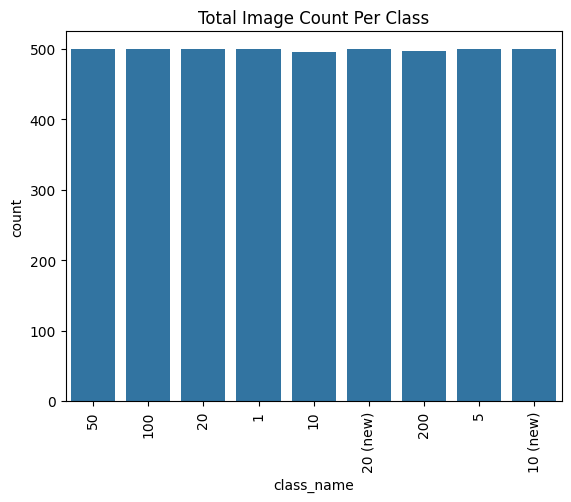

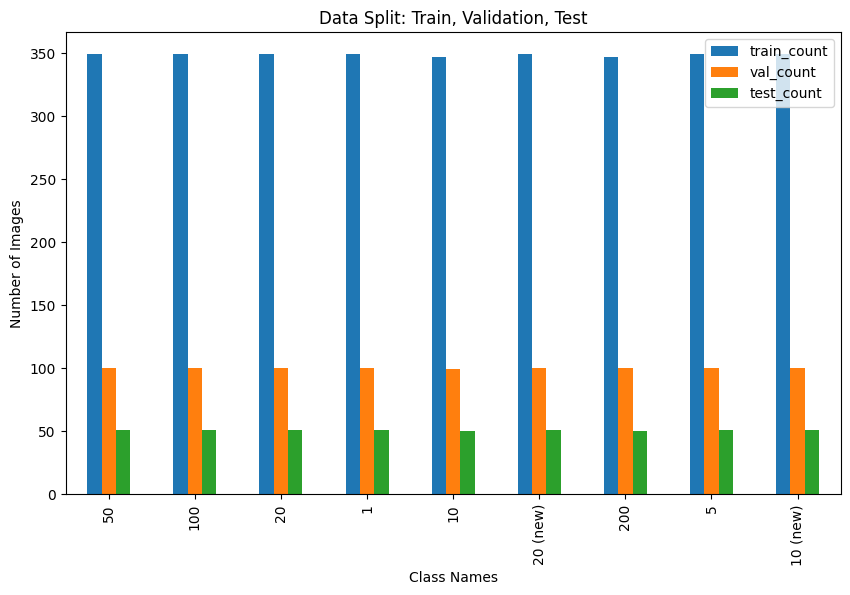

In [ ]:
import os
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# المسار الخاص بك
output_dir = pathlib.Path(r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance")

# قائمة أسماء الفئات
class_names = os.listdir(output_dir)

num_classes = len(class_names)
total = 0
all_count = []
class_name = []

# حساب عدد الصور في كل فئة
for i in range(num_classes):
    count = len(list(output_dir.glob(f"{class_names[i]}/*.jpg")))  # استخدام pathlib.Path
    total += count

print(f"Total image count = {total} \n")
print("-------------------------------------")

# عرض النسب والفئات
for i in range(num_classes):
    count = len(list(output_dir.glob(f"{class_names[i]}/*.jpg")))
    print(f"Class name = {class_names[i]}")
    print(f"Count      = {count}")
    print(f"Proportion = {count / total:.4f}")
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(class_names[i])

# إنشاء DataFrame وتحليل البيانات
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns=['count', 'class_name'])

# تقسيم البيانات إلى تدريب، تحقق، واختبار
train_size = 0.7  # 70% تدريب
val_size = 0.2   # 15% تحقق
test_size = 0.1  # 15% اختبار

# تقسيم البيانات لكل فئة
train_count = []
val_count = []
test_count = []

for i in range(num_classes):
    # تقسيم البيانات العشوائي
    class_path = output_dir / class_names[i]
    images = list(class_path.glob("*.jpg"))
    train_images, temp_images = train_test_split(images, test_size=(val_size + test_size), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(test_size / (val_size + test_size)), random_state=42)

    # حفظ الأعداد
    train_count.append(len(train_images))
    val_count.append(len(val_images))
    test_count.append(len(test_images))

# إنشاء DataFrame لعرض نتائج التقسيم
split_df = pd.DataFrame({
    'class_name': class_names,
    'train_count': train_count,
    'val_count': val_count,
    'test_count': test_count
})

# دمج البيانات الأصلية مع تقسيم البيانات
merged_df = pd.merge(temp_df, split_df, on='class_name')
# عرض توزيع الصور في كل فئة
sns.barplot(data=merged_df, y="count", x="class_name")
plt.title("Total Image Count Per Class")
plt.xticks(rotation=90)
plt.show()

# عرض الرسم البياني
merged_df.set_index('class_name')[['train_count', 'val_count', 'test_count']].plot(kind='bar', figsize=(10, 6))
plt.title("Data Split: Train, Validation, Test")
plt.ylabel("Number of Images")
plt.xlabel("Class Names")
plt.xticks(rotation=90)
plt.show()



In [ ]:
img_transforms  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0932, -0.0971, -0.1260], std=[0.5091, 0.4912, 0.4931])
])

In [ ]:
import torchvision.datasets as datasets # or import torchvision.datasets
# Load the data
data_dir = r"/root/.cache/kagglehub/datasets/belalsafy/egyptian-new-currency-2023/versions/1/dataset/balance"  # Adjust based on dataset structure

dataset = datasets.ImageFolder(data_dir, transform=img_transforms)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size =int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

                              # create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

len(train_dataloader), len(validation_dataloader), len(test_dataloader)

(99, 29, 15)

In [ ]:
# setting up torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

In [ ]:
# Initialize ResNet50 (You can use any other ResNet version)
resnet_model = models.resnet50(pretrained=True)

# Freeze the parameters of the model so that they won't be updated during training
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, len(class_names))  # Set the number of output classes

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
epochs = 30

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.3MB/s]


In [ ]:
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

# Variables to track the best model
best_model_wts = deepcopy(resnet_model.state_dict())
best_val_acc = 0.0  # Initialize best_val_acc to 0.0

ep_train_loss = []
ep_train_acc = []
ep_val_loss = []
ep_val_acc = []

# Early stopping variables
patience = 5
trigger_times = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

# Training Loop with Validation (No Testing)
for epoch in range(epochs):
    # ======= Training Phase =======
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_acc = correct / total * 100
    ep_train_loss.append(epoch_train_loss)
    ep_train_acc.append(epoch_train_acc)

    # ======= Validation Phase =======
    resnet_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient calculation during evaluation
        for inputs, labels in validation_dataloader:  # Use validation_dataloader for validation
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)

            # Update validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(validation_dataloader)
    epoch_val_acc = val_correct / val_total * 100
    ep_val_loss.append(epoch_val_loss)
    ep_val_acc.append(epoch_val_acc)

    # Check for best model based on validation accuracy
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_wts = deepcopy(resnet_model.state_dict())  # Save the best model weights
        trigger_times = 0  # Reset patience counter
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Step the scheduler
    scheduler.step(epoch_val_acc)

    # Print metrics for the epoch
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%, "
          f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%")

# Load the best model weights
resnet_model.load_state_dict(best_model_wts)

print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

Epoch [1/30], Train Loss: 1.4917, Train Accuracy: 50.57%, Validation Loss: 0.9979, Validation Accuracy: 72.33%
Epoch [2/30], Train Loss: 0.9178, Train Accuracy: 73.08%, Validation Loss: 0.7758, Validation Accuracy: 76.78%
Epoch [3/30], Train Loss: 0.7124, Train Accuracy: 79.17%, Validation Loss: 0.6282, Validation Accuracy: 84.22%
Epoch [4/30], Train Loss: 0.6218, Train Accuracy: 82.06%, Validation Loss: 0.5670, Validation Accuracy: 83.00%
Epoch [5/30], Train Loss: 0.5708, Train Accuracy: 82.70%, Validation Loss: 0.5286, Validation Accuracy: 83.22%
Epoch [6/30], Train Loss: 0.5008, Train Accuracy: 84.83%, Validation Loss: 0.4610, Validation Accuracy: 85.89%
Epoch [7/30], Train Loss: 0.4746, Train Accuracy: 85.52%, Validation Loss: 0.4294, Validation Accuracy: 87.11%
Epoch [8/30], Train Loss: 0.4538, Train Accuracy: 85.97%, Validation Loss: 0.4132, Validation Accuracy: 87.11%
Epoch [9/30], Train Loss: 0.4286, Train Accuracy: 86.41%, Validation Loss: 0.3955, Validation Accuracy: 87.78%
E

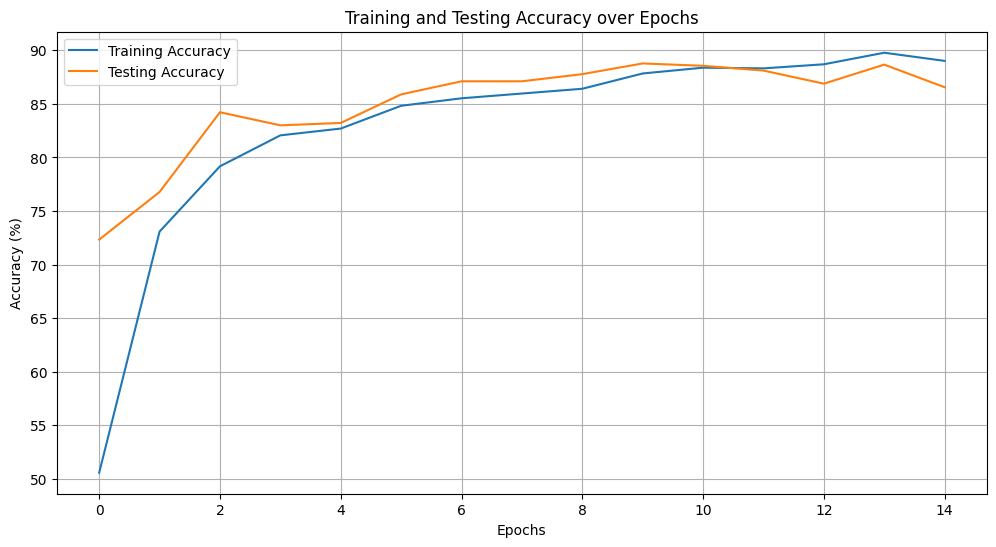

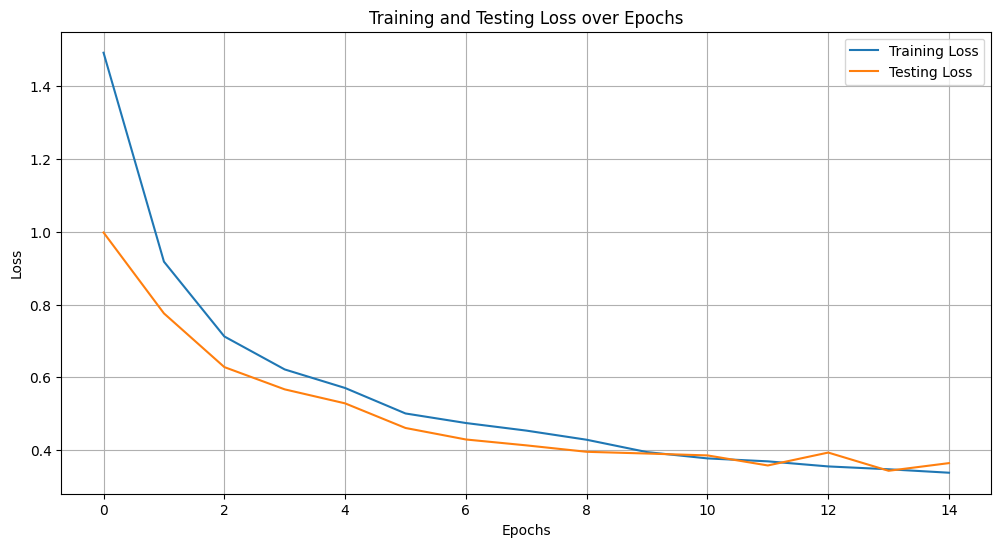

In [ ]:
import matplotlib.pyplot as plt

# رسم الدقة
plt.figure(figsize=(12, 6))
plt.plot(ep_train_acc, label="Training Accuracy")
plt.plot(ep_val_acc, label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# رسم الخسارة
plt.figure(figsize=(12, 6))
plt.plot(ep_train_loss, label="Training Loss")
plt.plot(ep_val_loss, label="Testing Loss")
plt.title("Training and Testing Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Model Accuracy: 84.00%
Model Precision: 85.73%
Model Recall: 84.00%
Model F1 Score: 84.37%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       0.97      0.71      0.82        51
           2       0.98      0.92      0.95        51
           3       0.66      0.72      0.69        29
           4       0.61      0.82      0.70        38
           5       1.00      0.86      0.93        58
           6       0.80      0.87      0.83        52
           7       0.73      0.81      0.77        53
           8       0.84      0.81      0.83        70

    accuracy                           0.84       450
   macro avg       0.84      0.84      0.83       450
weighted avg       0.86      0.84      0.84       450



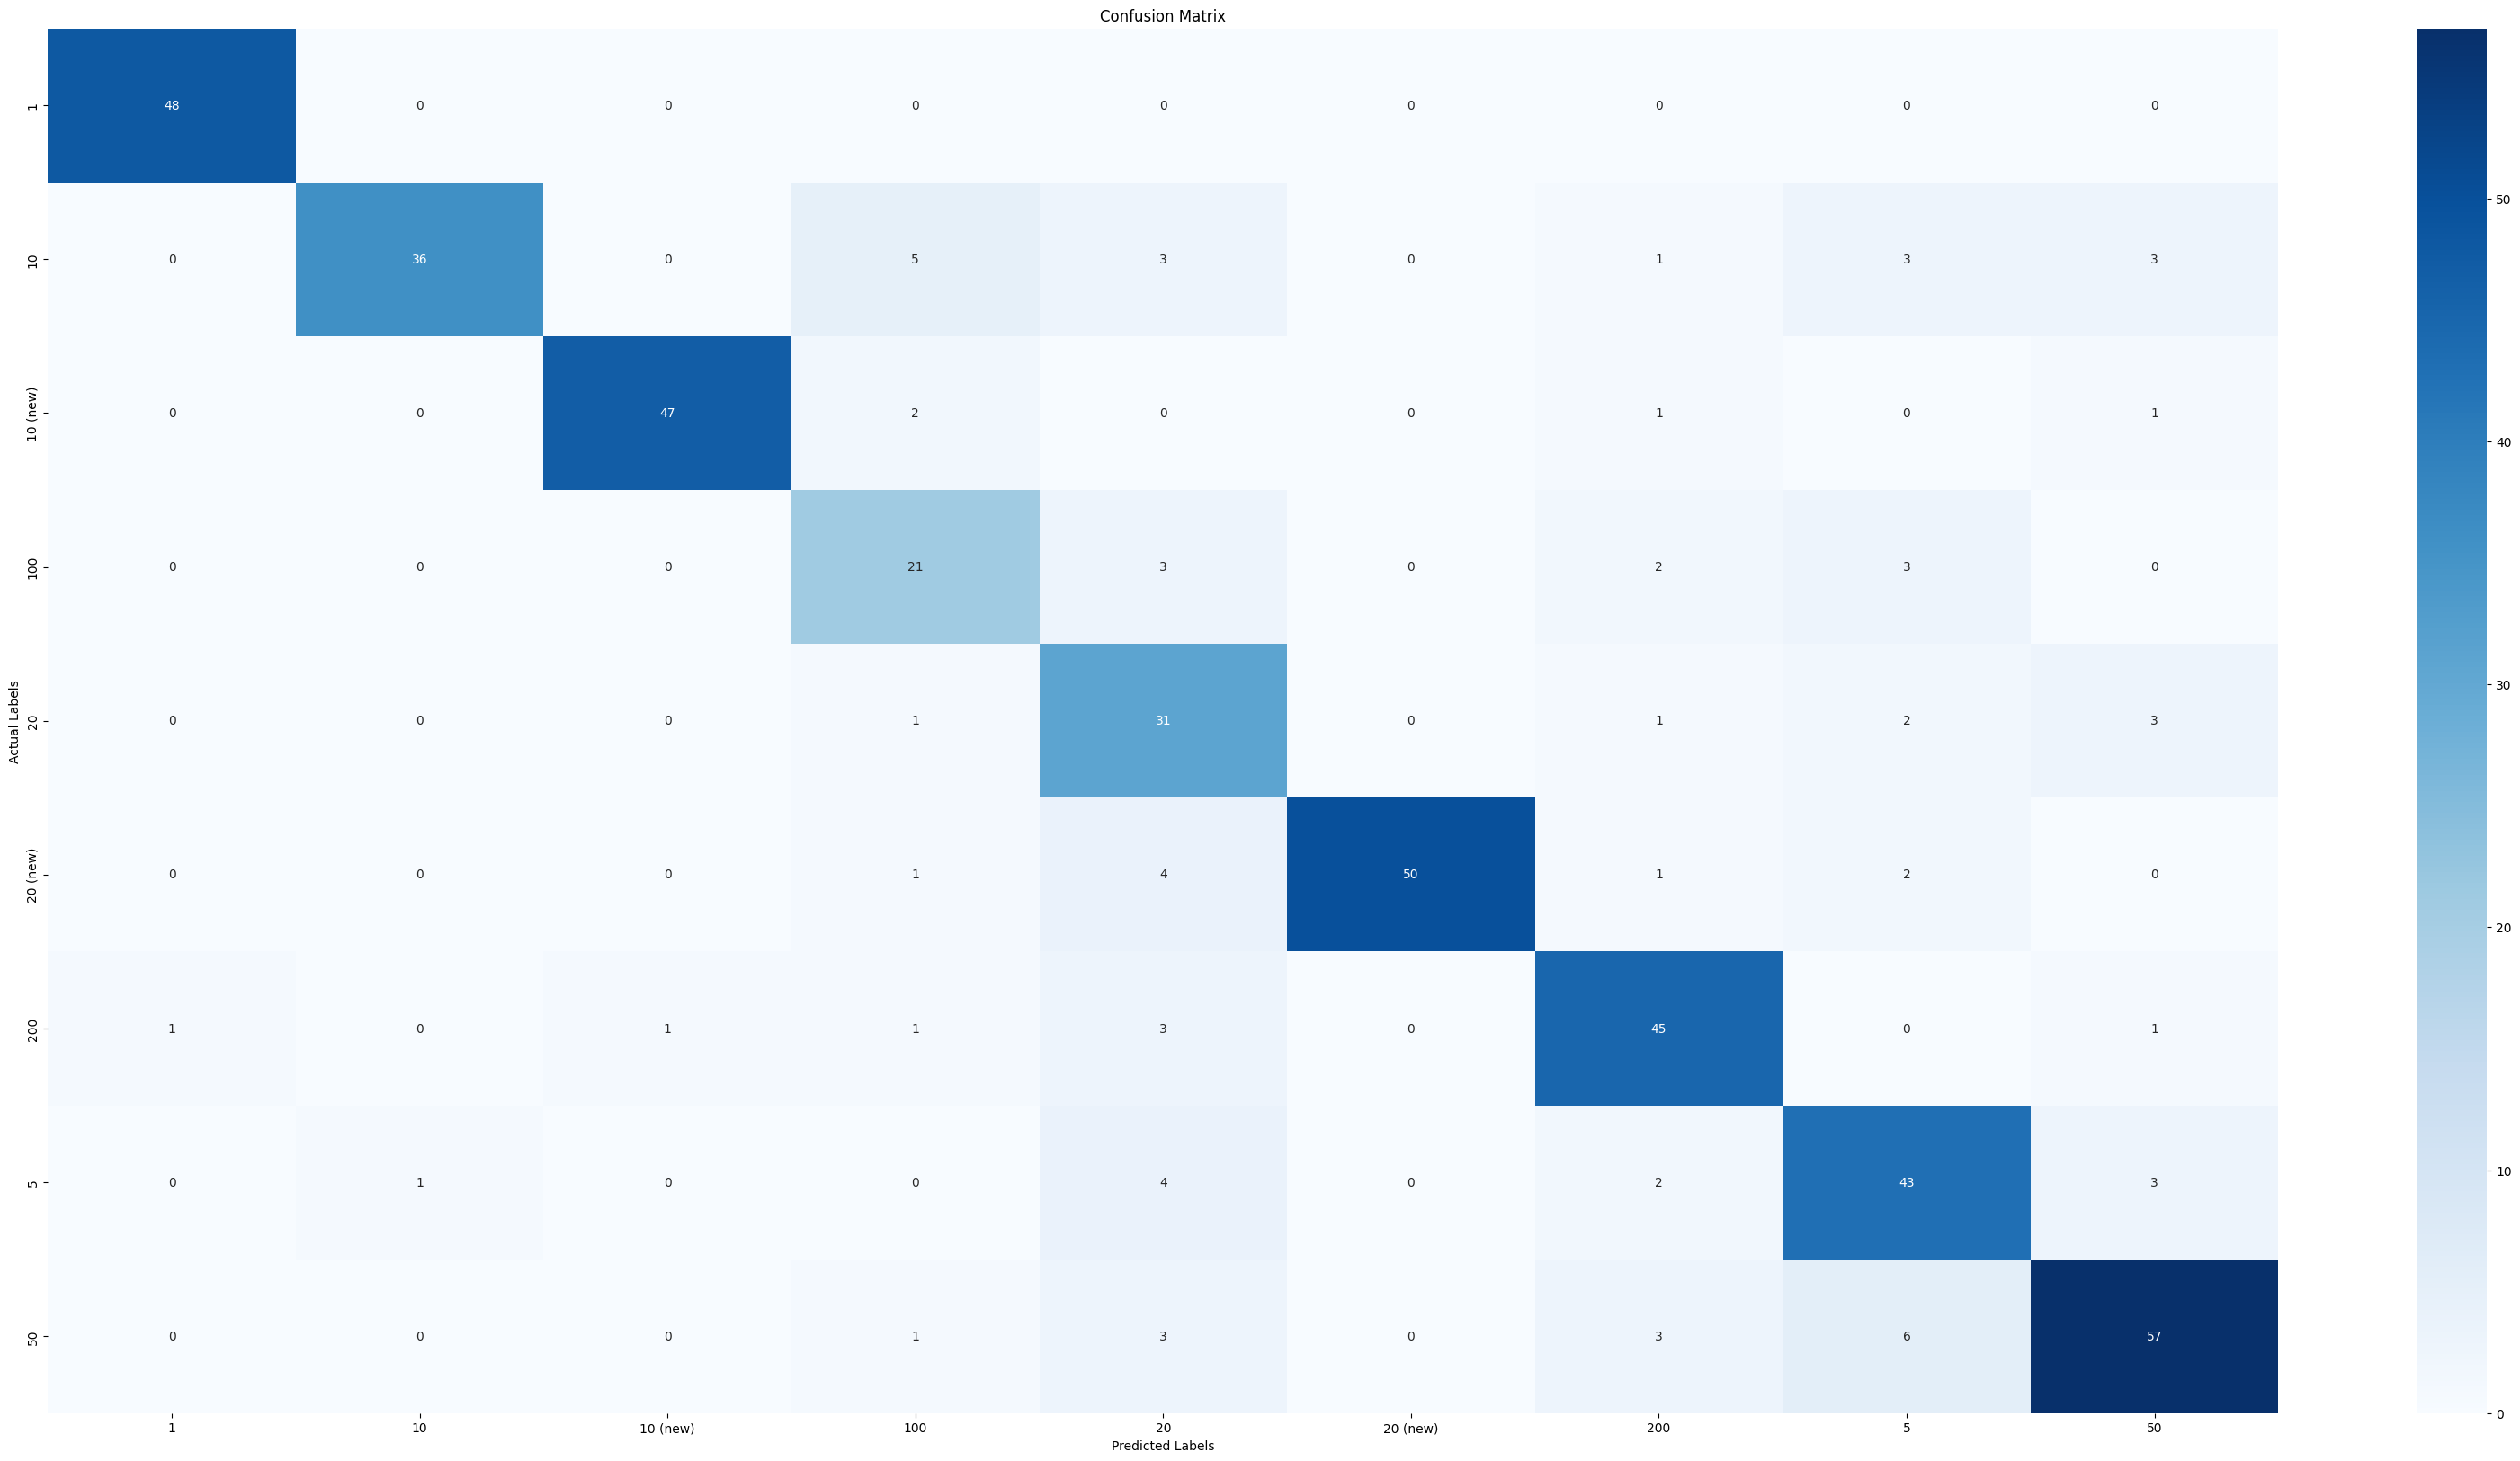

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
# Assuming `test_dataloader` is used for testing
actual_labels = []
predicted_labels = []

# Ensure model is in evaluation mode
resnet_model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass to get predictions
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append the true labels and predicted labels
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Print metrics
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

# Print classification report
print(classification_report(actual_labels, predicted_labels, zero_division=0))

# Generate and visualize confusion matrix
# Generate and visualize confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# If 'test_dataloader' is a subset, use 'test_dataloader.dataset' to get the full dataset
class_names = test_dataloader.dataset.dataset.classes  # Accessing the full dataset for classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()



In [ ]:
# save model
torch.save(best_model_wts,"/root/.cache/kagglehub/model.pth")



In [ ]:
# Assuming resnet_model is your model instance
resnet_model.load_state_dict(torch.load('/root/.cache/kagglehub/model.pth')) # Load the state dict into the model
resnet_model.eval() # Set the model to evaluation mode
resnet_model.to(device) # Move the model to the device (GPU if available)

<ipython-input-20-e0fe701ee6d3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('/root/.cache/kagglehub/model.pth')) # Load the stat

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
correct_count, all_count = 0,0
# data_test is a PosixPath object and is not iterable,
# it needs to be changed to test_dataloader
for images, labels in test_dataloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].unsqueeze(0)
        with torch.no_grad():
            # the variable model is undefined, likely it should be resnet_model
            logps = resnet_model(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 450

 Model Accuracy= 86.0


In [ ]:
transform_tests = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[-0.0932, -0.0971, -0.1260], std=[0.5091, 0.4912, 0.4931])  # Normalize the image
])


In [ ]:
def pred_class(img):
    # transform images
    img_tens = transform_tests(img) # transform_tests is now defined
    img_im = img_tens.unsqueeze(0).cuda()
    #uinput = Variable(img_im) # use Variable
    uinput = img_im.to(device)
    # model was undefined, it likely should be resnet_model
    out = resnet_model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()
    return index

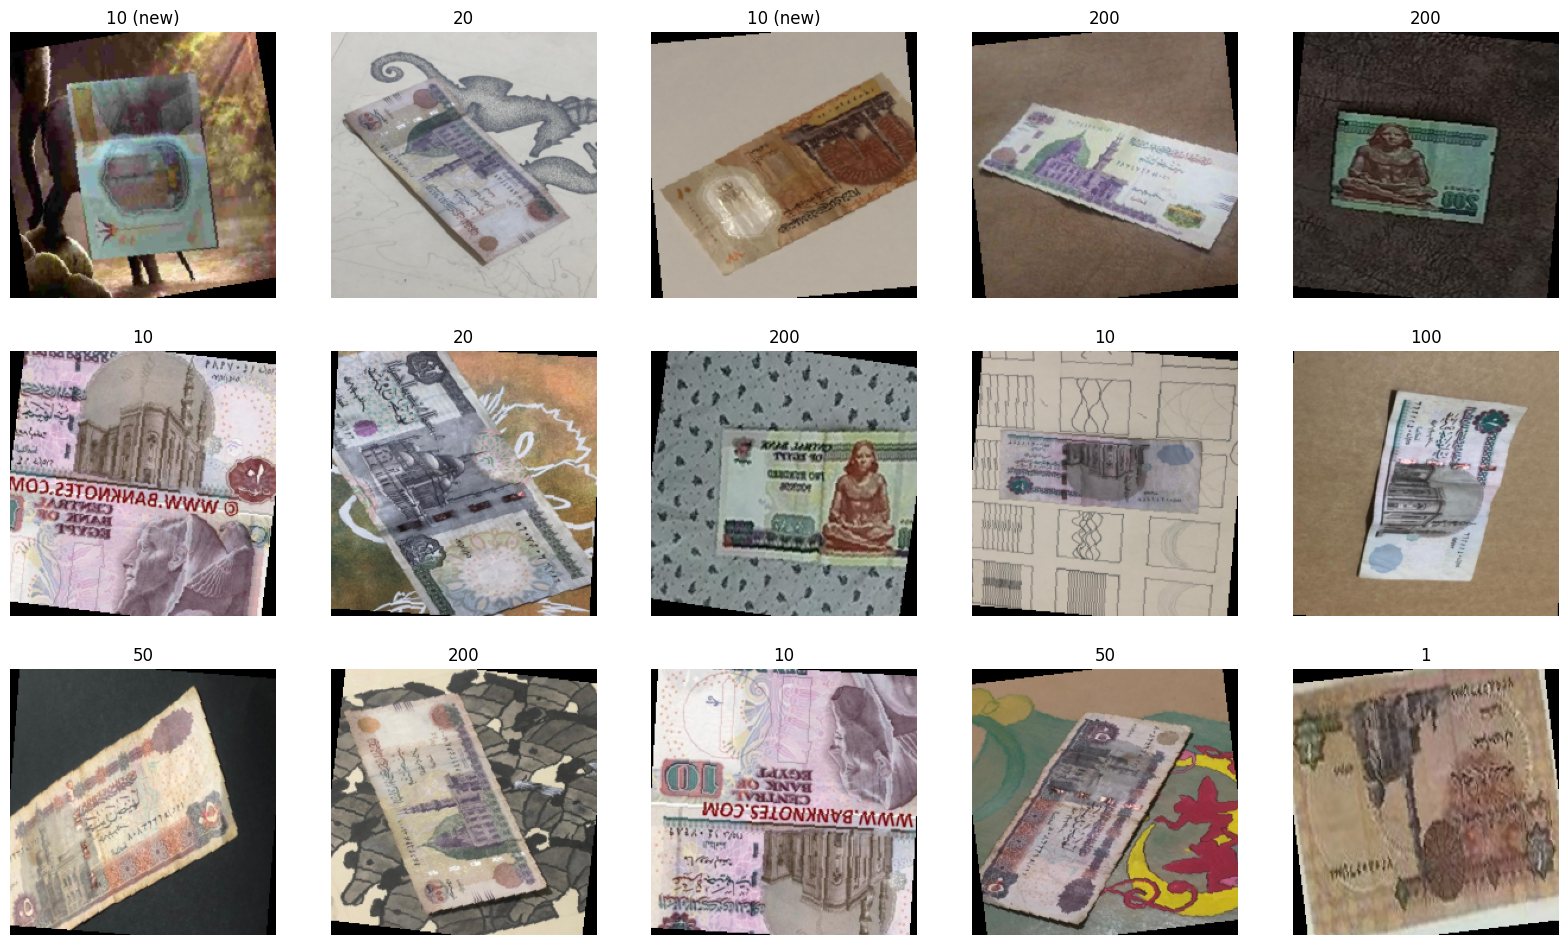

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

classes = {k: v for k, v in enumerate(sorted(class_names))} # Replace outcomes with class_names
resnet_model.eval()

plt.figure(figsize=(20,20))

for i, (images, labels) in enumerate(test_dataloader):
    # just want 25 images to print
    if i >30:
        break

    # Convert the image tensor to a PIL Image
    image = images[0]  # Get the first image from the batch
    image = image.cpu()  # Move to CPU if necessary

    # Denormalize the image
    # Assuming you normalized with mean=[-0.0932, -0.0971, -0.1260] and std=[0.5091, 0.4912, 0.4931]
    mean = torch.tensor([-0.0932, -0.0971, -0.1260])
    std = torch.tensor([0.5091, 0.4912, 0.4931])
    image = image * std[:, None, None] + mean[:, None, None]

    # Convert to PIL Image and display
    image = torchvision.transforms.ToPILImage()(image)

    # Make prediction
    index = pred_class(image)
    plt.subplot(5, 5, i + 1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(image)

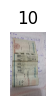

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# ... (rest of the code) ...
img="/content/drive/My Drive/5.jpeg"
# Load the image using PIL.Image.open()
img_pil = Image.open(img)

# No need to convert to PIL Image again, as img_pil is already a PIL Image
image = img_pil

# Make prediction
index = pred_class(image)
plt.subplot(5, 5, i + 1)
plt.title(classes[index])
plt.axis('off')
plt.imshow(image)